# Testing Parapineal Ablation Data on a new Ipython notebook based Thunder script

To start this file through pyspark use :
`$SPARK_HOME/bin/pyspark --jars /Users/seetha/anaconda/lib/python2.7/site-packages/thunder/lib/thunder_2.10-0.5.1.jar --driver-class-path /Users/seetha/anaconda/lib/python2.7/site-packages/thunder/lib/thunder_2.10-0.5.1.jar`

### Decorators

In [1]:
def format_for_linegraphplotting(plotting_function):
    def wrapper(*args, **kwargs):
        
        current_palette = sns.color_palette()
        ax1.set_color_cycle(current_palette)


        for key, value in kwargs.iteritems():
            if key=='xlim_input':
                ax1.set_xlim(value)
            if key=='num_bins':
                ax1.locator_params(axis='y', nbins=value)
            if key=='ylim_input':
                ax1.set_ylim(value)
                
        fs.patch.set_facecolor('black')
        
        for loc, spine in ax1.spines.items():
            spine.set_color('white')
            spine.set_linewidth(0.5)
        
        ax1.set_axis_bgcolor('black')
        ax1.title.set_color('white')
        ax1.yaxis.label.set_color('white')
        ax1.xaxis.label.set_color('white')        
        ax1.tick_params(axis='both', colors='white', 
                        direction='out', labelsize=15)        
        ax1.get_xaxis().tick_bottom()
        ax1.get_yaxis().tick_left()
        
        plotting_function(*args, **kwargs)
        
    return wrapper

### Set up Plotting

In [2]:
#Set seaborn plotting formats
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('notebook')

In [3]:
# Plot planes in the given image as subplot
def PlotImagePlanes(img):
    numz = np.size(img,2)
    num_subplots = int((math.ceil(numz / 2.) * 2)/2)

    fig1 = plt.figure(figsize=(15,10))
    for ii in xrange(0, numz):    
        ax1 = fig1.add_subplot(num_subplots,2,ii+1)
        ax1 = image(img[:,:,ii])    
        ax1.title.set_color('white')
        plt.title('Plane: ' + str(ii+1), fontsize=12)
    plt.show()

## 1. Run Thunder

In [4]:
# Create new config - To avoid maxResultSize error. Stop Spark context and reload ThunderContext
from thunder import ThunderContext
from pyspark import SparkConf, SparkContext

conf = (SparkConf()
    .set("spark.driver.maxResultSize", "0"))

sc.stop()
# Create new thunder context using the configuration
tsc = ThunderContext.start(appName="thunderpca", conf=conf)

## 2. Get user input

In [5]:
#Provide Folder from which to get data
foldername = '/Users/seetha/Desktop/Parapineal_Ablation/Data/01_Zoom=2/Tiff/Sorted/Red_First/Fish1159/Block3/'

## 3. Load Libraries

In [6]:
#Matplotlib plots to be inline in the notebook
%matplotlib inline

In [7]:
#Import Python libraries
import matplotlib.pyplot as plt
import numpy as np
import math
import os
import glob
import shutil
from progressbar import ProgressBar

In [8]:
#Import Thunder libraries
from thunder import Colorize
image = Colorize.image

## 4 Load Images from Folder using Thunder Context

In [9]:
#Load data as tif
data = tsc.loadImages(foldername, inputFormat='tif-stack')

### a. Do some plotting

In [11]:
examples = data.toTimeSeries().subset(nsamples=100, thresh=1)

In [12]:
print np.shape(examples)

(100, 285)


In [16]:
to_plot = np.mean(examples,axis=0)

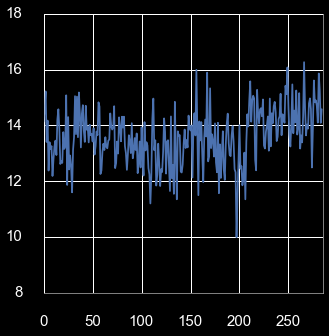

In [18]:
fs = plt.figure(figsize=(5,5))
ax1 = fs.add_subplot((111))
@format_for_linegraphplotting
def plot_mean(fs, ax1, data_to_plot, **kwargs):    
    plt.plot(to_plot)
    plt.show()
plot_mean(fs, ax1, to_plot, num_bins=5, xlim_input=[0,285])

In [ ]:
print examples.dims.count

In [ ]:
# Get the first image in data and plot
img = data.first()[1]
PlotImagePlanes(img)

In [ ]:
# Print some info on the data
print 'Shape of first image: ' + str(np.shape(img))
print 'Number of dimensions of data ' + str(data.dims)
print 'Total number of time points ' + str(data.nrecords)

In [ ]:
# Looking at images with paricular indices and plot
index = 28
img = data[index]
PlotImagePlanes(img)
print 'Shape of image number '+ str(index) + ' : '+ str(np.shape(img))

## 5. Max Projection of planes, Standard Deviations

In [ ]:
# Plot maximum projections and standard deviation
projs = data.maxProjection(axis=2)
img = projs[index]
fig1 = plt.figure(figsize=(10,10))
image(img)

In [ ]:
img = data.stdev()

In [ ]:
PlotImagePlanes(img)

In [ ]:
print np.shape(img)

## 6. Save as series

In [ ]:
#Create binary folder
binaryfolder = os.path.join(foldername, 'Binary_Files')
if not os.path.exists(binaryfolder):
        os.makedirs(binaryfolder)  
else:
    #Overwrite if binary file is present
    if glob.glob(binaryfolder+'/*.bin'):
        overwrite_flag = True
    else:
        overwrite_flag = False
        
print 'Saving to...' + binaryfolder

#Save to series
data.saveAsBinarySeries(binaryfolder, overwrite=overwrite_flag) #Warning: if overwrite=True the whole directory is erased

In [ ]:
# Convert to html
!ipython nbconvert --to html Load_ImageData_ToSeries.ipynb

In [ ]:
#Save in appropriate folder
path_list = foldername.split(os.sep)
fishnumber = [s for s in path_list if "Fish" in s]
blocknumber = [s for s in path_list if "Block" in s]
filenamesuffix = str(fishnumber)[2:-2] + '_' + str(blocknumber)[2:-2] +'_'
savefolder = os.path.join(foldername, 'Ipython_NB/')
if not os.path.exists(savefolder):
        os.makedirs(savefolder)  
        
os.rename(os.path.join(os.getcwd(),"Load_ImageData_ToSeries.html"), os.path.join(savefolder, filenamesuffix+"PlotImageData.html"))
shutil.copy(os.path.join(os.getcwd(),"Load_ImageData_ToSeries.ipynb"), os.path.join(savefolder, filenamesuffix+"PlotImageData.ipynb"))